In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')  # Move the kaggle.json file

In [7]:
!kaggle datasets list

ref                                                          title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
jayaantanaath/student-habits-vs-academic-performance         Student Habits vs Academic Performance                    19512  2025-04-12 10:49:08.663000          23501        402  1.0              
adilshamim8/cost-of-international-education                  Cost of International Education                           18950  2025-05-07 15:41:53.213000           4787         80  1.0              
adilshamim8/social-media-addiction-vs-relationships          Students' Social Media Addiction                           7851  2025-05-10 14:38:02.713000           2218         35  1.0              
fatemehmoh

In [8]:
!kaggle datasets download -d theblackmamba31/landscape-image-colorization

Dataset URL: https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization
License(s): unknown
 66% 127M/192M [00:00<00:00, 1.32GB/s]
100% 192M/192M [00:00<00:00, 927MB/s] 


In [9]:
!unzip landscape-image-colorization.zip

Streaming output truncated to the last 5000 lines.
  inflating: landscape Images/gray/2914.jpg  
  inflating: landscape Images/gray/2915.jpg  
  inflating: landscape Images/gray/2916.jpg  
  inflating: landscape Images/gray/2917.jpg  
  inflating: landscape Images/gray/2918.jpg  
  inflating: landscape Images/gray/2919.jpg  
  inflating: landscape Images/gray/292.jpg  
  inflating: landscape Images/gray/2920.jpg  
  inflating: landscape Images/gray/2921.jpg  
  inflating: landscape Images/gray/2922.jpg  
  inflating: landscape Images/gray/2923.jpg  
  inflating: landscape Images/gray/2924.jpg  
  inflating: landscape Images/gray/2925.jpg  
  inflating: landscape Images/gray/2926.jpg  
  inflating: landscape Images/gray/2927.jpg  
  inflating: landscape Images/gray/2928.jpg  
  inflating: landscape Images/gray/2929.jpg  
  inflating: landscape Images/gray/293.jpg  
  inflating: landscape Images/gray/2930.jpg  
  inflating: landscape Images/gray/2931.jpg  
  inflating: landscape Images/g

In [ ]:
!pip install tensorflow opencv-python matplotlib tqdm numpy scikit-image

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

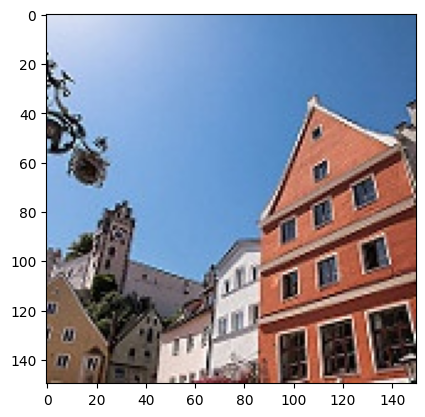

In [10]:
# Load an example image before normalization
sample_image = cv2.imread("/content/landscape Images/color/7081.jpg")
image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)  # Convert to RGB

plt.imshow(image)
plt.show()

In [11]:
# Define image size for lower memory usage
IMG_SIZE = 128
NUM_IMAGES = 2500  # Limit to 1000 images
BATCH_SIZE = 32  # Small batch size to save RAM

# Function to sort filenames correctly
def sorted_alphanumeric(data):
    import re
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    return sorted(data, key=lambda key: [convert(c) for c in re.split('([0-9]+)', key)])

def load_images(bw_folder, color_folder):
    bw_images, color_images = [], []

    bw_files = sorted_alphanumeric(os.listdir(bw_folder))[:NUM_IMAGES]
    color_files = sorted_alphanumeric(os.listdir(color_folder))[:NUM_IMAGES]

    for bw_file, color_file in tqdm(zip(bw_files, color_files), total=len(bw_files)):
        bw_path = os.path.join(bw_folder, bw_file)
        color_path = os.path.join(color_folder, color_file)

        # Read and resize
        bw_img = cv2.imread(bw_path)
        bw_img = cv2.cvtColor(bw_img, cv2.COLOR_BGR2GRAY) # Convert to Grayscale
        color_img = cv2.imread(color_path)
        color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)

        if bw_img is None or color_img is None:
            continue

        bw_img = cv2.resize(bw_img, (IMG_SIZE, IMG_SIZE))
        color_img = cv2.resize(color_img, (IMG_SIZE, IMG_SIZE))

        # Normalize to [0, 1]
        bw_img = bw_img.astype(np.float32) / 255.0
        color_img = color_img.astype(np.float32) / 255.0

        # Add extra channel for grayscale
        bw_img = np.expand_dims(bw_img, axis=-1)

        bw_images.append(bw_img)
        color_images.append(color_img)

    return np.array(bw_images), np.array(color_images)

# Load dataset
bw_images, color_images = load_images("/content/landscape Images/gray", "/content/landscape Images/color")

# Convert to TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((bw_images, color_images)).shuffle(NUM_IMAGES).batch(BATCH_SIZE)


100%|██████████| 2500/2500 [00:02<00:00, 1152.51it/s]


[1855, 797, 2004, 970, 688]


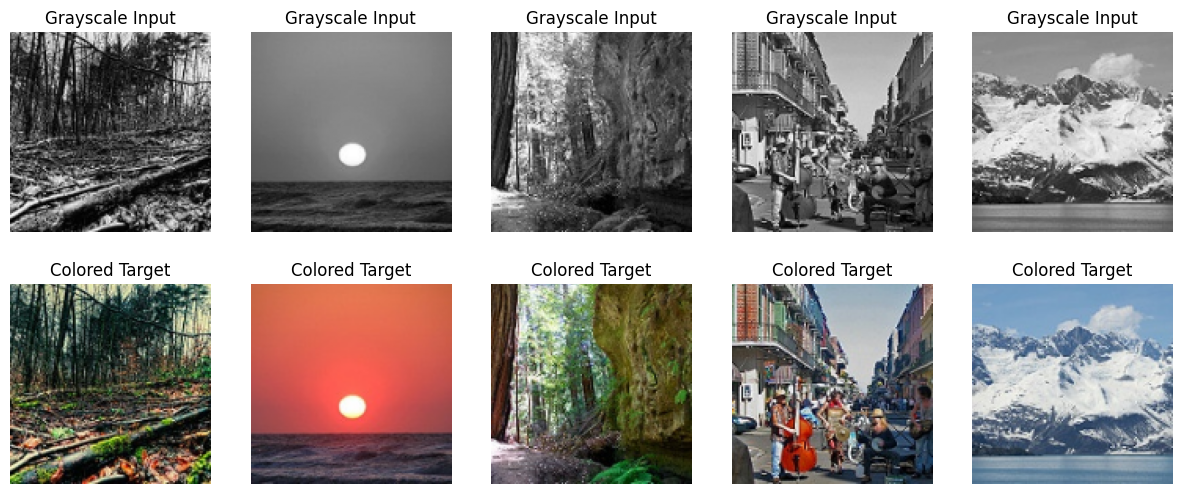

In [18]:
import random

# Function to visualize 5 sample images
def show_sample_images(bw_images, color_images):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    # Select 5 random indices
    indices = random.sample(range(len(bw_images)), 5)
    print(indices)

    for i, idx in enumerate(indices):
        # Grayscale Image
        axes[0, i].imshow(bw_images[idx].squeeze(), cmap="gray")
        axes[0, i].set_title("Grayscale Input")
        axes[0, i].axis("off")

        # Corresponding Color Image
        axes[1, i].imshow(color_images[idx])
        axes[1, i].set_title("Colored Target")
        axes[1, i].axis("off")

    plt.show()

# Call function to display samples
show_sample_images(bw_images, color_images)


In [37]:
def build_generator():
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    def downsample(filters):
        return keras.Sequential([
            layers.Conv2D(filters, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU()
        ])
    def upsample(filters):
        return keras.Sequential([
            layers.Conv2DTranspose(filters, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU()
        ])
    down_stack = [downsample(32), downsample(64), downsample(128), downsample(256)]
    up_stack = [upsample(128), upsample(64), upsample(32)]
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    x = last(x)
    return keras.Model(inputs=inputs, outputs=x)
generator = build_generator()
generator.summary()
 # Saves the generator model


Model: "functional_235"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_14       │ (None, 64, 64,    │        640 │ input_layer_20[0… │
│ (Sequential)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 32, 32,    │     33,024 │ sequential_14[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_16       │ (None, 16, 16,    │    131,584 │ sequential_15[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 8, 8, 256) │    525,312 │ sequential_16[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_18       │ (None, 16, 16,    │    524,800 │ sequential_17[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 16, 16,    │          0 │ sequential_18[0]… │
│ (Concatenate)       │ 256)              │            │ sequential_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_19       │ (None, 32, 32,    │    262,400 │ concatenate_8[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 32, 32,    │          0 │ sequential_19[0]… │
│ (Concatenate)       │ 128)              │            │ sequential_15[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_20       │ (None, 64, 64,    │     65,664 │ concatenate_9[0]… │
│ (Sequential)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 64, 64,    │          0 │ sequential_20[0]… │
│ (Concatenate)       │ 64)               │            │ sequential_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_11 │ (None, 128, 128,  │      3,075 │ concatenate_10[0… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,546,499 (5.90 MB)

 Trainable params: 1,545,091 (5.89 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [38]:
def build_discriminator():
    inp = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 1])
    tar = layers.Input(shape=[IMG_SIZE, IMG_SIZE, 3])
    x = layers.Concatenate()([inp, tar])

    down1 = layers.Conv2D(32, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    down1 = layers.LeakyReLU()(down1)
    down2 = layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer='he_normal', use_bias=False)(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)

    last = layers.Conv2D(1, 4, strides=1, padding='same', kernel_initializer='he_normal')(down2)

    return keras.Model(inputs=[inp, tar], outputs=last)

discriminator = build_discriminator()
discriminator.summary()


Model: "functional_236"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_29      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 128, 128,  │          0 │ input_layer_28[0… │
│ (Concatenate)       │ 4)                │            │ input_layer_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │      2,048 │ concatenate_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 64, 64,    │          0 │ conv2d_18[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │     32,768 │ leaky_re_lu_16[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_17      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32, 1) │      1,025 │ leaky_re_lu_17[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,097 (141.00 KB)

 Trainable params: 35,969 (140.50 KB)

 Non-trainable params: 128 (512.00 B)

In [39]:
loss_object = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + (100 * l1_loss)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss


In [40]:
generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

from tensorflow.keras.models import load_model
generator = load_model('/content/drive/MyDrive/AAI/generator_model.h5')
discriminator = load_model('/content/drive/MyDrive/AAI/discriminator_model.h5')
generator.compile(optimizer=generator_optimizer, loss=loss_object)
discriminator.compile(optimizer=discriminator_optimizer, loss=loss_object)

@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_optimizer.apply_gradients(zip(gen_tape.gradient(gen_loss, generator.trainable_variables), generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_tape.gradient(disc_loss, discriminator.trainable_variables), discriminator.trainable_variables))

def train(dataset, epochs=5):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for bw, color in dataset:
            train_step(bw, color)

train(dataset, epochs=20)
generator.save('/content/drive/MyDrive/AAI/generator_model.h5')
discriminator.save('/content/drive/MyDrive/AAI/discriminator_model.h5')


Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [ ]:
!pip install scikit-image

Selected indices: [2465 2022 1170]


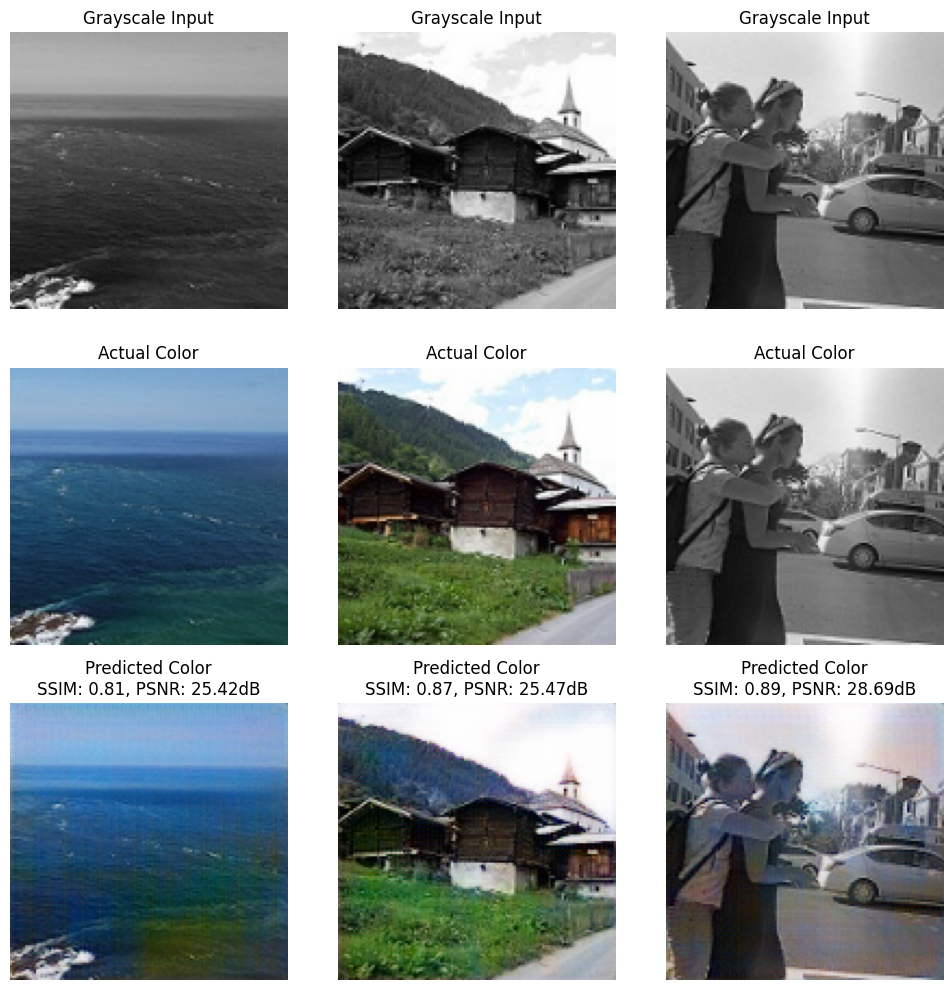

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import cv2  # Needed for Lab MSE function
from tensorflow import keras
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.models import load_model

# SSIM (Structural Similarity Index Measure), SSIM = 1 → perfect match, SSIM closer to 0 → not similar
# PSNR (Peak Signal-to-Noise Ratio), Higher PSNR = less difference = cleaner image, PSNR above 30 dB(decibels) = good
loss_object = keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

generator = load_model('/content/drive/MyDrive/AAI/generator_model.h5')


# Function to display 3 test images with ground truth and predictions + show SSIM & PSNR
def generate_images(model, test_bw, test_color):
    idx = np.random.choice(len(test_bw), 3, replace=False)  # Pick 3 random indices
    print("Selected indices:", idx)
    test_bw_sample = test_bw[idx]
    test_color_sample = test_color[idx]

    prediction = model(test_bw_sample, training=False)  # Get predicted color images
    data_range=1.0

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    for i in range(3):
        input_gray = test_bw_sample[i].squeeze()
        real_color = test_color_sample[i]
        pred_color = np.clip(prediction[i].numpy(), 0, 1)

        # SSIM & PSNR
        ssim_score = ssim(real_color, pred_color, channel_axis=-1, data_range=1.0)  # For skimage>=0.19
        psnr_score = psnr(real_color, pred_color, data_range=1.0)

        axes[0, i].imshow(input_gray, cmap="gray")
        axes[0, i].set_title("Grayscale Input")
        axes[0, i].axis("off")

        axes[1, i].imshow(real_color)
        axes[1, i].set_title("Actual Color")
        axes[1, i].axis("off")

        axes[2, i].imshow(pred_color)
        axes[2, i].set_title(f"Predicted Color\nSSIM: {ssim_score:.2f}, PSNR: {psnr_score:.2f}dB")
        axes[2, i].axis("off")

    plt.tight_layout()
    plt.show()

# Generate and display images + evaluation
generate_images(generator, bw_images, color_images)


In [49]:
def lab_ab_mse(img1, img2):
    """
    Computes MSE between the a and b channels of two RGB images in Lab space.
    Assumes img1 and img2 are normalized RGB images (range [0,1]).
    """
    lab1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_RGB2LAB).astype(np.float32)
    lab2 = cv2.cvtColor((img2 * 255).astype(np.uint8), cv2.COLOR_RGB2LAB).astype(np.float32)

    # Normalize a and b channels from [-128,127] to [0,1]
    ab1 = (lab1[:, :, 1:3] + 128.0) / 255.0
    ab2 = (lab2[:, :, 1:3] + 128.0) / 255.0

    return np.mean((ab1 - ab2) ** 2)


def evaluate_model_on_dataset(model, bw_images, color_images, num_samples=100):
    """
    Evaluate average SSIM, PSNR, and Lab MSE over a subset of the dataset.
    """
    from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

    ssim_total = 0.0
    psnr_total = 0.0
    lab_mse_total = 0.0
    count = min(num_samples, len(bw_images))

    for i in range(count):
        input_gray = np.expand_dims(bw_images[i], axis=0)
        real_color = color_images[i]
        pred_color = np.clip(model(input_gray, training=False)[0].numpy(), 0, 1)

        ssim_total += ssim(real_color, pred_color, channel_axis=-1, data_range=1.0)
        psnr_total += psnr(real_color, pred_color, data_range=1.0)
        lab_mse_total += lab_ab_mse(real_color, pred_color)

    avg_ssim = ssim_total / count
    avg_psnr = psnr_total / count
    avg_lab_mse = lab_mse_total / count

    print(f"✅ Average SSIM: {avg_ssim:.4f}")
    print(f"✅ Average PSNR: {avg_psnr:.2f} dB")
    print(f"✅ Average Lab MSE: {avg_lab_mse:.4f}")

evaluate_model_on_dataset(generator, bw_images, color_images, num_samples=100)


✅ Average SSIM: 0.8840
✅ Average PSNR: 26.39 dB
✅ Average Lab MSE: 0.0011
